In [0]:
try:
  import tflearn # try to import tflearn
except ImportError:
  !pip3 install -q tflearn # install tflearn first 
  import tflearn # then import it

In [0]:
import matplotlib.pyplot as plt # used for plotting images
import numpy as np # to do math functions
import os, sys # to interact with file system
import tensorflow as tf # tensorflow during training
from tflearn.activations import relu # rectified linear activation function

# normalizes data 
from tflearn.layers.normalization import batch_normalization as bn
from scipy.misc import imread, bytescale, imresize # image manipulation functions
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d, global_avg_pool
from tflearn.layers.estimator import regression # trainer for the network

# turns scalar label inot vector where appropriate class is value 1 and others 9
from tflearn.data_utils import to_categorical

# makes new images from the ones we have by flipping them, rotating, ect.
from tflearn.data_augmentation import ImageAugmentation

from tensorflow.contrib.tensorboard.plugins import projector

In [0]:
def install_tensorboard_dep():
  '''installs tensorboard to be used in colab.'''
  if 'ngrok-stable-linux-amd64.zip' not in os.listdir(os.getcwd()):
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip
    os.system('n')

In [0]:
def montage(x, plot_shape=(15, 15), return_grid=False, cmap='viridis'):
  '''
  Takes in a 4-D tensor, x, of shape [NxHxWxC] and puts all of the images
  together in a single matrix to show as one image. If return_grid is True, 
  it will not show the matrix, but return it to be used in some other 
  operations.
  '''
  
  count = 0
  if not return_grid:
    scale = [0, 255]
  else:
    scale = [0, 1]
  
  
  if len(x.shape) == 4 and x.shape[-1] == 3:
    num, m, n, c = x.shape
  else:
    num, m, n = x.shape
    c = 1
    
  num = int(np.ceil(np.sqrt(num)))
  grid = np.zeros([num*m, num*n, c])
  
  if c == 1:
    grid = grid[..., 0]
  
  for i in range(num):
    for j in range(num):
      if count < x.shape[0]:
        if c == 1:
          grid[i*m:i*m+m, j*n:j*n+n] = bytescale(x[count, ...], 
                                                 low=scale[0], high=scale[1])
        else:
          grid[i*m:i*m+m, j*n:j*n+n, :] = bytescale(x[count, ...],
                                                    low=scale[0], high=scale[1])
        count += 1 
        
  if return_grid:
    return grid
  else:
    fig = plt.figure(figsize=plot_shape)
    a1 = fig.add_subplot(111)
    a1.set_xticks(np.arange(-0.5, num*n, n))
    a1.set_yticks(np.arange(-0.5, num*m, m))
    a1.set_yticklabels([])
    a1.set_xticklabels([])
    a1.imshow(grid, cmap=cmap)
    plt.show()

In [0]:
def start_tensorboard():
  '''Starts tensorboard on colaboratory.'''
  LOG_DIR = '/tmp/tflearn_logs'
  get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))
  get_ipython().system_raw('./ngrok http 6006 &')
  ! curl -s http://localhost:4040/api/tunnels | python3 -c \
  "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [0]:
def viz_embedding(tensor, images, labels, shape):
  ''''''
  
  tb_dir = '/tmp/tflearn_logs'
  sess = tf.Session()
  sess.run(tensor.initializer)
  summary_writer = tf.summary.FileWriter(tb_dir)
  config = projector.ProjectorConfig()
  embedding = config.embeddings.add()
  embedding.tensor_name = tensor.name
  embedding.metadata_path = os.path.join(tb_dir, 'metadata.tsv')
  embedding.sprite.image_path = os.path.join(tb_dir, 'flowers.png') 
  embedding.sprite.single_image_dim.extend(shape)
  projector.visualize_embeddings(summary_writer, config)
  saver = tf.train.Saver([tensor])
  saver.save(sess, os.path.join(tb_dir, 'flowers.ckpt'), 1)
  
  image_grid = montage(images, return_grid=True)
  plt.imsave(os.path.join(tb_dir, 'flowers.png'), image_grid)
  
  with open(os.path.join(tb_dir, 'metadata.tsv'),'w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(labels):
      f.write("%d\t%d\n" % (index,label))
  f.close()

In [153]:
response = input ('DO you want to train a network? (y/n) ') # ask user if they want to train or load

# if input was Y, y, Yes, or yes, Train a network. If not, load a trained one in.
if response in ['Y', 'y', 'Yes', 'yes',]:
  Train = True
else:
  Train = false

DO you want to train a network? (y/n) y


In [0]:
# import dataset loader from tflearn
import tflearn.datasets.oxflower17 as oxflower17

# load the data in as X and the labels in as Y
X, Y = oxflower17.load_data(one_hot=True, resize_pics=(150, 150))


In [155]:
print(X.shape, Y.shape) # print the shape of data and labels
print(Y[:10, ...]) # print first 10 label vectors

(1360, 150, 150, 3) (1360, 17)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


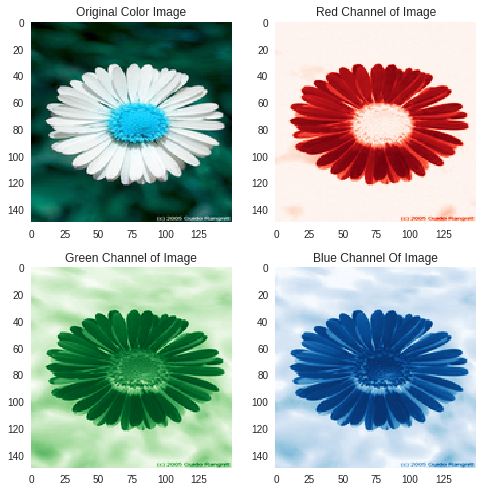

In [156]:
fig = plt.figure(figsize=(7,7)) # create a figure of size 7x7
a1 = fig.add_subplot(221) # add the first of fours subplots in the figure
a2 = fig.add_subplot(222) # add the second of four subplots in the figure
a3 = fig.add_subplot(223) # add the third of the four subplots
a4 = fig.add_subplot(224) # add the fourth of the four subplots

x_show = X[0, :, :, ::-1] # get the first image from the dataset

a1.imshow(bytescale(x_show)) # show the original image
a2.imshow(x_show[..., 0], cmap='Reds') # show the first color channel (red) of the image
a3.imshow(x_show[..., 1], cmap='Greens') # show the second color channel (green) of the image
a4.imshow(x_show[..., 2], cmap='Blues') # show the third color channel (blue) of the image

# remove the grid and tick lines
a1.grid(False)
a2.grid(False)
a3.grid(False)
a4.grid(False)

# name the subplot
a1.set_title('Original Color Image')
a2.set_title('Red Channel of Image')
a3.set_title('Green Channel of Image')
a4.set_title('Blue Channel Of Image')

plt.tight_layout()

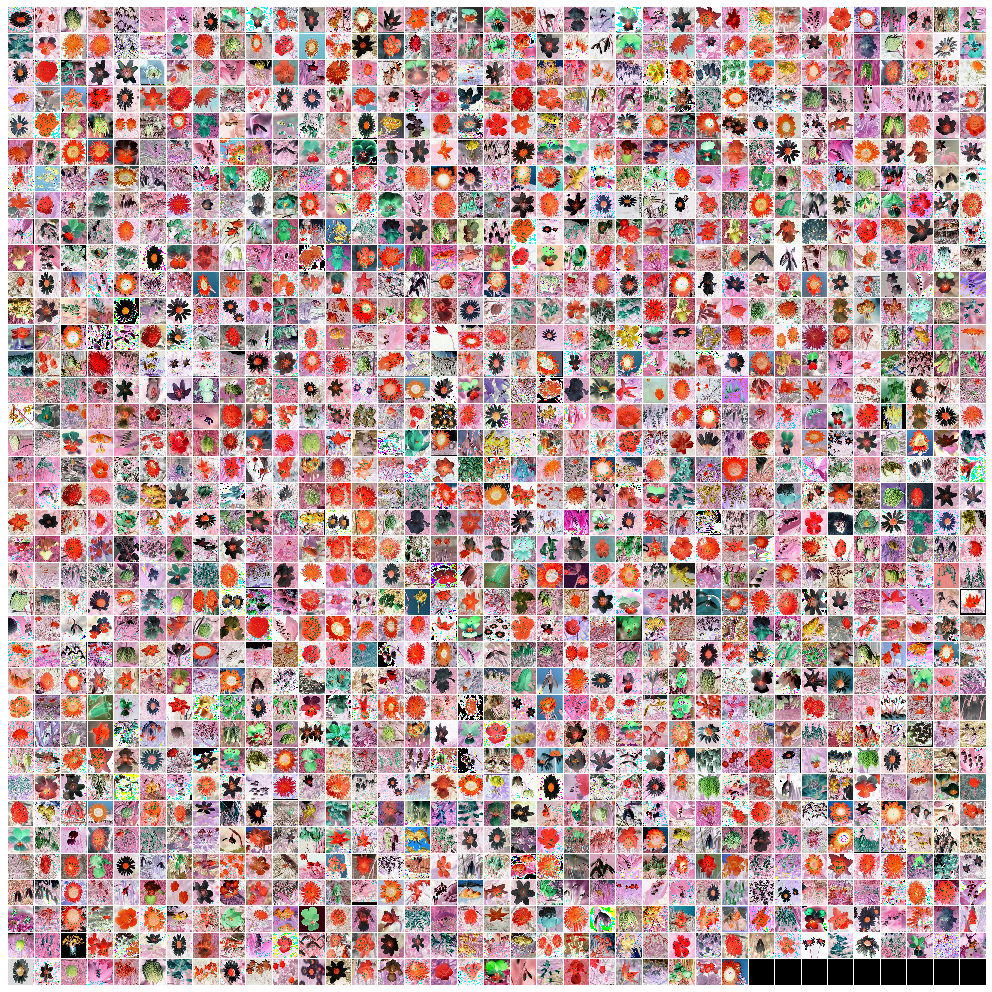

In [157]:
montage(X[..., ::-1], (18, 18))

In [0]:
random_img = X[100, ...] # take the 100th image from the dataset
weight_filter = np.random.randn(5, 5, 3) # make random weights
output_feature_map = np.zeros([random_img.shape[0], random_img.shape[1]]) # create empty feature map

In [0]:
for i in range(random_img.shape[0]-5): # loop through rows
  for j in range(random_img.shape[0]-5): #loop through columns
    output_feature_map[i, j] = np.sum(weight_filter * random_img[i:i+5, j:j+5, :]) # weighted sum

In [160]:
print(np.amax(output_feature_map), np.amin(output_feature_map))

2.7124767483025924 -13.377587171349742


In [0]:
output_feauture_map = bytescale(output_feature_map)

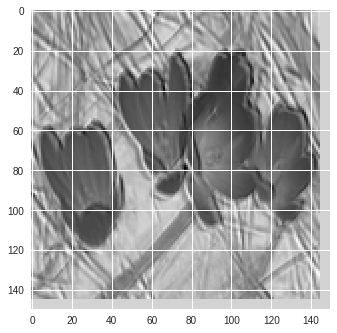

In [162]:
plt.imshow(output_feature_map, cmap='gray')

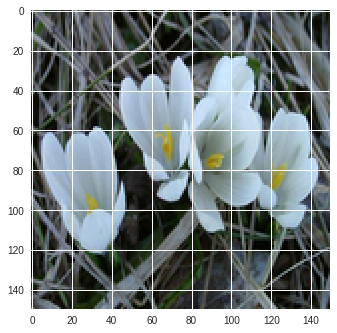

In [163]:
plt.imshow(random_img)

In [0]:
# make negative activation values 0 and keep positive ones - rectified linear activation
output_feature_map = np.int32(output_feature_map > 0) * output_feature_map

In [165]:
print(output_feature_map.shape)

(150, 150)


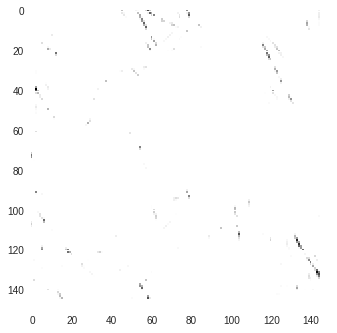

In [166]:
plt.imshow(np.float32(output_feature_map))

(array([2515748., 1970901., 1271388., 1831295., 1176952., 1750327.,
        1154911., 1727703., 1163294., 1716089., 1713582., 1138158.,
        1696632., 1133004., 1683842., 1110720., 1658613., 1105884.,
        1650764., 1078074., 1597916., 1584430., 1039727., 1540190.,
        1009702., 1501586.,  994556., 1476760.,  970707., 1433303.,
        1406113.,  922733., 1357350.,  888378., 1310056.,  866204.,
        1277732.,  836260., 1235241.,  808561., 1190542., 1170592.,
         768601., 1128441.,  732964., 1074155.,  701244., 1024838.,
         669354.,  974687.,  949644.,  622067.,  908548.,  593716.,
         877349.,  573999.,  850167.,  562083.,  820562.,  536725.,
         791542.,  778159.,  510491.,  757984.,  499769.,  741845.,
         489462.,  728432.,  485462.,  710574.,  702556.,  461258.,
         679423.,  445237.,  659305.,  431860.,  639862.,  422443.,
         631124.,  409200.,  620001.,  608083.,  390823.,  573901.,
         386288.,  544991.,  357308.,  525271., 

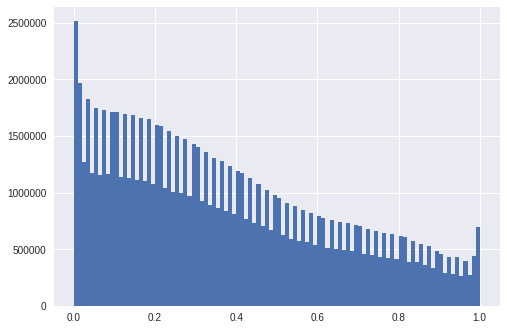

In [167]:
plt.hist(X.flatten(), bins = 100) # view histogram of normalized data

In [0]:
#preprocess by substracting mean and dividing by standard deviation
X -= np.mean(X, 0) #center each pixel value around 0
X /= np.std(X, 0) # squash each pixel between -1 and 1

In [169]:
print(output_feature_map.shape)

(150, 150)


(array([8.500000e+02, 5.138000e+03, 1.051000e+04, 2.470000e+04,
        4.701700e+04, 7.110600e+04, 9.616300e+04, 1.265980e+05,
        1.608530e+05, 2.050790e+05, 2.683990e+05, 3.692090e+05,
        5.376390e+05, 7.226600e+05, 9.138760e+05, 1.098721e+06,
        1.186553e+06, 1.318424e+06, 1.722892e+06, 2.431488e+06,
        3.097687e+06, 2.965051e+06, 2.831240e+06, 2.743220e+06,
        2.668492e+06, 2.606146e+06, 2.552019e+06, 2.489261e+06,
        2.438239e+06, 2.380082e+06, 2.328344e+06, 2.275094e+06,
        2.218963e+06, 2.155262e+06, 2.095439e+06, 2.036062e+06,
        1.981009e+06, 1.921053e+06, 1.863723e+06, 1.814711e+06,
        1.759551e+06, 1.701695e+06, 1.643042e+06, 1.590110e+06,
        1.539037e+06, 1.487762e+06, 1.440064e+06, 1.396617e+06,
        1.358046e+06, 1.313775e+06, 1.274276e+06, 1.231569e+06,
        1.187732e+06, 1.147266e+06, 1.104270e+06, 1.068364e+06,
        1.030883e+06, 9.920060e+05, 9.207030e+05, 8.449390e+05,
        7.750920e+05, 6.923360e+05, 6.37

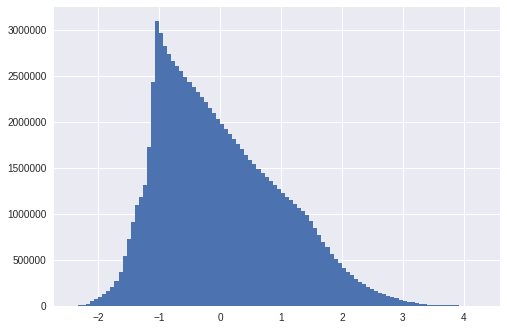

In [170]:
plt.hist(X.flatten(), bins=100) # view histogram of normalized data

In [171]:
print(np.mean(X), np.std(X))

-1.158065e-06 0.9999984


In [0]:
tf.reset_default_graph() #reset the tensorflow graph

In [0]:
#augment images
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright() #randomly flip some images left to right
img_aug.add_random_rotation(max_angle=33.) # randomly rotate images up to 33 degrees
img_aug.add_random_crop((150, 150), padding=15) # randomly crop a 120 x 120 frame out of images

In [0]:
# create a layer to view data space in tensorboard
emb = tf.Variable(X[::10, ...], name='input_flower_images')

In [0]:
# tflearn documentation --- http://tflearn.org/

# create input layer that takes in images and augments them as well
in_layer = input_data(shape=[None, 150, 150, 3], data_augmentation=img_aug)

# have 64, 7x7 filters over the input images
conv1 = conv_2d(in_layer, 64, 7, activation='linear', name='1c')

# normalize conv1 layer and feature map 
batch_norm1 = bn(conv1, name='bn1')

# perform relu activation function
relu1 = relu(batch_norm1)

# max pooling
pool1 = max_pool_2d(relu1, 3, 2)

# second conv layer with 128, 3x3 filters
conv2 = conv_2d(pool1, 128, 3, activation='linear', name='2c')

#second normalization layer
batch_norm2 = bn(conv2, name='bn2')

# second relu layer
relu2 = relu(batch_norm2)

# max pooling layer 2
pool2 = max_pool_2d(relu2, 3, 2)

# conv3 layer
conv3 = conv_2d(pool2,256, 3, activation='linear', name='c3')

# normalize c3 layer
batch_norm3 = bn(conv3, name='bn3')

# relu on normalized c3 heat maps --- num_images x 37 x 37 x 256
relu3 = relu(batch_norm3)

# take the average of each of the 256 feature maps --- num_images  x 1 x 1 x 256
gap = global_avg_pool(relu3)

#output layer --- softmax turns output values into probabilities
out_layer = fully_connected(gap, 17, activation='softmax', name='fc')

In [0]:
# describe how to optimize the network's weights
network = regression(out_layer, optimizer='adam',
                    loss='categorical_crossentropy', learning_rate=.001)

In [0]:
# build the network based on the description above
model = tflearn.DNN(network, tensorboard_verbose=2)

In [178]:
# name for tensoboard
tensorboard_name = 'flowers_cnn'

# send the visualization to tensorboard via our function
viz_embedding(emb, X[::10, ...], np.argmax(Y[::10, ...], 1), [150, 150, 3])

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'ImageAugmentation' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'dict' object has no attribute 'name'


In [179]:
# start tensorboard --- might need to run this code cell twice
install_tensorboard_dep()
start_tensorboard()

http://97a7ffaf.ngrok.io


In [0]:
if Train:
  model.fit(X, # input data 
            Y, # corresponding labels 
            n_epoch=50, # number of times to go through entire dataset
            shuffle=True, #  shuttle the images each epoch 
            validation_set=0.1, # use 10% for validation
            show_metric=True, # show validation accuracy/loss in tensorboard
            batch_size=50, # go through dataset 50 examples at a time
            run_id= 'OxfordFlowers_CNN') # name that will show up on tensorboard
  
  # saved the trained model for later as the name in red
  model.save('flowers_CNN')

Training Step: 1249  | total loss: 0.55177 | time: 14.350s
| Adam | epoch: 050 | loss: 0.55177 - acc: 0.8320 -- iter: 1200/1224
Training Step: 1250  | total loss: 0.54924 | time: 15.923s
| Adam | epoch: 050 | loss: 0.54924 - acc: 0.8348 | val_loss: 1.05602 - val_acc: 0.6985 -- iter: 1224/1224
--
INFO:tensorflow:/content/flowers_CNN is not in all_model_checkpoint_paths. Manually adding it.


In [1]:
sess = tf.Session() # tensorflow session
sess.run(tf.global_variables_initializer())

NameError: ignored

In [0]:
def load_layer(layer_name, data):
  '''A function to retrieve feature maps with name layer_name from the model given input data.'''
  layer = sess.run(layer_name, {in_layer:data})
  print (layer.shape)
  return layer

In [0]:
def view_feature_map(layer):
  '''Takes in feature maps of shape NHWC and plots every one using the montage function'''
  n, h, c = layer.shape # get layer's shape
  layer = layer.transporse((0, 3, 1, 2)).reshape([n*c, h, w])
  montage(layer, cmap='gray')

In [0]:
# choose 1 random number between 0 and the number of examples in the dataset
random_index = np.random.randint(0, X.shape[0], 1)[0]

# take out the image at that spot to use
new_img = X[random_index,...]

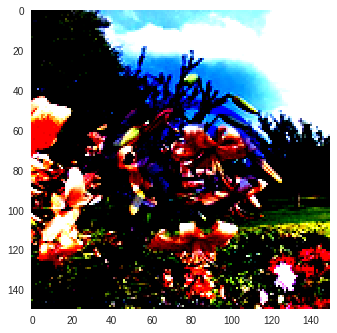

In [120]:
# view the original image
img_show = bytescale(new_img, 0, 1) # make values in new_img go between 0 and 1 to show it in matplotlib
plt.imshow(img_show) # tell it what to show
plt.grid(False) # get rid of the gridlines since this is not a graph
plt.show() # show the image

In [137]:
# view the first conv layer's feature maps --- 64 different views of the image to help decide what it is
view_feature_map(load_layer(conv1, new_img))

TypeError: ignored

In [126]:
# view results of the normalization layer
view_feature_map(load_layer(batch_norml, new_img))

NameError: ignored

In [127]:
# view results of the rectified linear layer
view_feature_map(load_layer(relu1, new_img))

ValueError: ignored

In [128]:
# view results of the pooling layer
view_feature_map(load_layer(pool1, new_img))

ValueError: ignored

In [140]:
# view the second conv layer's feature maps
view_feature_map(load_layer(conv2, new_img))

TypeError: ignored

In [141]:
# view results of the second normalization layer
view_feature_map(load_layer(batch_norm2, new_img))

TypeError: ignored

In [142]:
#view results of the second rectified linear layer
view_feature_map(load_layer(relu2, new_img))

TypeError: ignored

In [143]:
# view results of the pooling layer
view_feature_map(load_layer(pool2, new_img))

TypeError: ignored

In [144]:
# view the third conv layer's feature maps
view_feature_map(load_layer(conv3, new_img))

TypeError: ignored

In [145]:
# view results of the third normalization layer
view_feature_map(load_layer(btch_norm3, new_img))

NameError: ignored

In [146]:
# view results of the third rectified linear layer
view_feature_map(load_layer(relu3, new_img))

TypeError: ignored